# Advanced SQL: Kaggle 
[Advanced SQL](https://www.kaggle.com/learn/advanced-sql])

In [20]:
from IPython.display import Image
from IPython.core.display import HTML 

## Chapter 1 – JOINS & UNION

"Left" refers to the table that appears before the JOIN in the query. ("Right" refers to the table that is after the JOIN.)

In [2]:
Image(url= "https://i.imgur.com/1Dvmg8S.png")

## UNION
If you instead would like to vertically concatenate columns, you can do so with a UNION.

If you'd like to drop duplicate values, you need only change UNION ALL in the query to UNION DISTINCT

In [3]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

,id,by,author,time,time_ts,text,parent,deleted,dead,ranking
0,2701393,5l,5l,1309184881,2011-06-27 14:28:01+00:00,And the glazier who fixed all the broken windo...,2701243,None,None,0
1,5811403,99,99,1370234048,2013-06-03 04:34:08+00:00,Does canada have the equivalent of H1B/Green c...,5804452,None,None,0
2,21623,AF,AF,1178992400,2007-05-12 17:53:20+00:00,"Speaking of Rails, there are other options in ...",21611,None,None,0
3,10159727,EA,EA,1441206574,2015-09-02 15:09:34+00:00,Humans and large livestock (and maybe even pet...,10159396,None,None,0
4,2988424,Iv,Iv,1315853580,2011-09-12 18:53:00+00:00,I must say I reacted in the same way when I re...,2988179,None,None,0


In [6]:
# Construct a reference to the "stories" table
table_ref = dataset_ref.table("stories")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

,id,by,score,time,time_ts,title,url,text,deleted,dead,descendants,author
0,6940813,sarath237,0,1387536270,2013-12-20 10:44:30+00:00,Sheryl Brindo Hot Pics,http://www.youtube.com/watch?v=ym1cyxneB0Y,Sheryl Brindo Hot Pics,None,True,NaN,sarath237
1,6991401,123123321321,0,1388508751,2013-12-31 16:52:31+00:00,Are you people also put off by the culture of ...,,They&#x27;re pretty explicitly &#x27;startup f...,None,True,NaN,123123321321
2,1531556,ssn,0,1279617234,2010-07-20 09:13:54+00:00,New UI for Google Image Search,http://googlesystem.blogspot.com/2010/07/googl...,Again following on Bing's lead.,None,None,0.0,ssn
3,5012398,hoju,0,1357387877,2013-01-05 12:11:17+00:00,Historic website screenshots,http://webscraping.com/blog/Generate-website-s...,Python script to generate historic screenshots...,None,None,0.0,hoju
4,7214182,kogir,0,1401561740,2014-05-31 18:42:20+00:00,Placeholder,,Mind the gap.,None,None,0.0,kogir


In [5]:
# Query to select all stories posted on January 1, 2012, with number of comments
join_query = """
             WITH c AS
             (
             SELECT parent, COUNT(*) as num_comments
             FROM `bigquery-public-data.hacker_news.comments` 
             GROUP BY parent
             )
             SELECT s.id as story_id, s.by, s.title, c.num_comments
             FROM `bigquery-public-data.hacker_news.stories` AS s
             LEFT JOIN c
             ON s.id = c.parent
             WHERE EXTRACT(DATE FROM s.time_ts) = '2012-01-01'
             ORDER BY c.num_comments DESC
             """

# Run the query, and return a pandas DataFrame
join_result = client.query(join_query).result().to_dataframe()
join_result.head()

,story_id,by,title,num_comments
0,3412900,whoishiring,Ask HN: Who is Hiring? (January 2012),154.0
1,3412901,whoishiring,Ask HN: Freelancer? Seeking freelancer? (Janua...,97.0
2,3412643,jemeshsu,Avoid Apress,30.0
3,3412891,Brajeshwar,"There's no shame in code that is simply ""good ...",27.0
4,3414012,ramanujam,Impress.js - a Prezi like implementation using...,27.0


In [7]:
join_result.tail()

,story_id,by,title,num_comments
439,3412634,wslh,Cracks in the BRIC wall,NaN
440,3412871,tashmi,Pop rock music radio online,NaN
441,3413989,ukdm,GRAIL-A Spacecraft Arrives at the Moon,NaN
442,3413145,jacquesm,CUDA Textbook - IAP 2009 CUDAMIT / 6.963,NaN
443,3412395,gsivil,Ask PG: HNY and what about some hi-res icons f...,NaN


Next, we write a query to select all usernames corresponding to users who wrote stories or comments on January 1, 2014. We use **UNION DISTINCT** (instead of UNION ALL) to ensure that each user appears in the table at most once.

In [8]:
# Query to select all users who posted stories or comments on January 1, 2014
union_query = """
              SELECT c.by
              FROM `bigquery-public-data.hacker_news.comments` AS c
              WHERE EXTRACT(DATE FROM c.time_ts) = '2014-01-01'
              UNION DISTINCT
              SELECT s.by
              FROM `bigquery-public-data.hacker_news.stories` AS s
              WHERE EXTRACT(DATE FROM s.time_ts) = '2014-01-01'
              """

# Run the query, and return a pandas DataFrame
union_result = client.query(union_query).result().to_dataframe()
union_result.head()

,by
0,MWil
1,ericd
2,zeeboo
3,tgflynn
4,source99


In [9]:
# Number of users who posted stories or comments on January 1, 2014
len(union_result)

2282

## Stackoverflow example
Find users who joined the site in January 2019. You want to track their activity on the site: when did they post their first questions and answers, if ever?

In [17]:
%%bigquery

SELECT
  c.id as id,
  MIN(EXTRACT(DATE FROM q.creation_date)) AS q_creation_date,
  MIN(EXTRACT(DATE FROM a.creation_date)) AS a_creation_date
FROM
  `bigquery-public-data.stackoverflow.users` AS c
FULL JOIN
  `bigquery-public-data.stackoverflow.posts_questions` AS q
ON
  c.id = q.owner_user_id
FULL JOIN
  `bigquery-public-data.stackoverflow.posts_answers` AS a
ON
  c.id = a.owner_user_id
WHERE
  EXTRACT(DATE FROM c.creation_date) >= '2019-01-01'AND 
  EXTRACT(DATE FROM c.creation_date)<= '2019-01-31'
GROUP BY c.id
ORDER BY id

,id,q_creation_date,a_creation_date
0,10853220,None,None
1,10853221,None,None
2,10853222,None,None
3,10853223,2019-01-01,None
4,10853224,None,None
...,...,...,...
142445,11231243,2019-01-28,2019-01-31
142446,11486952,None,2019-05-14
142447,11525772,2019-05-20,2019-01-18
142448,12131663,None,None


In [15]:
%%bigquery

SELECT u.id AS id,
    MIN(EXTRACT(DATE FROM q.creation_date)) AS q_creation_date,
    MIN(EXTRACT(DATE FROM a.creation_date)) AS a_creation_date
FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
    FULL JOIN `bigquery-public-data.stackoverflow.posts_answers` AS a
        ON q.owner_user_id = a.owner_user_id 
    RIGHT JOIN `bigquery-public-data.stackoverflow.users` AS u
        ON q.owner_user_id = u.id
WHERE u.creation_date >= '2019-01-01' and u.creation_date < '2019-02-01'
GROUP BY id
ORDER BY id

,id,q_creation_date,a_creation_date
0,10853220,None,None
1,10853221,None,None
2,10853222,None,None
3,10853223,2019-01-01,None
4,10853224,None,None
...,...,...,...
142445,11231243,2019-01-28,2019-01-31
142446,11486952,None,None
142447,11525772,2019-05-20,2019-01-18
142448,12131663,None,None


## UNION

* When filtering by a date from datestamp, remember to extract the date.

In [18]:
%%bigquery

SELECT
  q.owner_user_id
FROM
  `bigquery-public-data.stackoverflow.posts_questions` AS q
WHERE
  EXTRACT(DATE FROM q.creation_date) = '2019-01-01'

UNION DISTINCT

SELECT
  a.owner_user_id
FROM
  `bigquery-public-data.stackoverflow.posts_answers` AS a
WHERE
  EXTRACT(DATE FROM a.creation_date) = '2019-01-01'

,owner_user_id
0,9151292.0
1,6449292.0
2,10690232.0
3,6091102.0
4,9915120.0
...,...
4705,381345.0
4706,453389.0
4707,1077346.0
4708,259889.0


## Chapter 2 – ANALYTIC FUNCTIONS; Window Functions

* Operate on a set of rows
* Return a (potentially different) value for each row in the original table

Examples: moving averages and running totals, among other quantities.

### Example 1
The average of the current and previous training sessions:

In [19]:
Image(url= "https://i.imgur.com/rehp8HM.png")

All analytic functions have an **OVER** clause, which defines the sets of rows used in each calculation. The **OVER** clause has three (optional) parts:

* The **PARTITION BY** clause divides the rows of the table into different groups. In the query above, we divide by id so that the calculations are separated by runner.
* The **ORDER BY** clause defines an ordering within each partition. In the sample query, ordering by the date column ensures that earlier training sessions appear first.
* The final clause (**ROWS BETWEEN 1 PRECEDING AND CURRENT ROW**) is known as a window frame clause. It identifies the set of rows used in each calculation. We can refer to this group of rows as a window. (Actually, analytic functions are sometimes referred to as **window functions**!)

In [22]:
Image(url="https://i.imgur.com/GjiKlA7.png")

There are many ways to write window frame clauses:

- `ROWS BETWEEN 1 PRECEDING AND CURRENT ROW` - the previous row and the current row.
- `ROWS BETWEEN 3 PRECEDING AND 1 FOLLOWING` - the 3 previous rows, the current row, and the following row.
- `ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING` - all rows in the partition.

For more Bigquery analytics functions please visit the resource [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/analytic-function-concepts)

### 1) Analytic aggregate functions
As you might recall, AVG() (from the example above) is an aggregate function. The OVER clause is what ensures that it's treated as an analytic (aggregate) function. Aggregate functions take all of the values within the window as input and return a single value.

`MIN() (or MAX())` - Returns the minimum (or maximum) of input values
`AVG() (or SUM())` - Returns the average (or sum) of input values
`COUNT()` - Returns the number of rows in the input

### 2) Analytic navigation functions
Navigation functions assign a value based on the value in a (usually) different row than the current row.

`FIRST_VALUE() (or LAST_VALUE())` - Returns the first (or last) value in the input
`LEAD() (and LAG())` - Returns the value on a subsequent (or preceding) row

### 3) Analytic numbering functions
Numbering functions assign integer values to each row based on the ordering.

`ROW_NUMBER()` - Returns the order in which rows appear in the input (starting with 1)
`RANK()` - All rows with the same value in the ordering column receive the same rank value, where the next row receives a rank value which increments by the number of rows with the previous rank value.


### San Francisco bikeshare-trips

In [23]:
# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "san_francisco" dataset
dataset_ref = client.dataset("san_francisco", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "bikeshare_trips" table
table_ref = dataset_ref.table("bikeshare_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,944732,2618,2015-09-24 17:22:00+00:00,Mezes,83,2015-09-24 18:06:00+00:00,Mezes,83,653,94063,Customer
1,984595,5957,2015-10-25 18:12:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,52,nil,Customer
2,984596,5913,2015-10-25 18:13:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,121,nil,Customer
3,1129385,6079,2016-03-18 10:33:00+00:00,Mezes,83,2016-03-18 12:14:00+00:00,Mezes,83,208,94070,Customer
4,1030383,5780,2015-12-06 10:52:00+00:00,Mezes,83,2015-12-06 12:28:00+00:00,Mezes,83,44,94064,Customer


In [34]:
%%bigquery

WITH
  most_frequent_days AS (
  SELECT
    DATE(start_date) AS trip_date,
    COUNT(*) AS num_trips
  FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
  WHERE
    EXTRACT(YEAR FROM start_date) = 2015
  GROUP BY
    trip_date
  ORDER BY
    num_trips DESC)

SELECT
  *,
  EXTRACT(DAYOFWEEK FROM trip_date) AS day_of_week,
FROM
  most_frequent_days
LIMIT 10

,trip_date,num_trips,day_of_week
0,2015-08-26,1465,4
1,2015-07-28,1451,3
2,2015-08-27,1443,5
3,2015-06-11,1437,5
4,2015-09-15,1423,3
5,2015-08-25,1421,3
6,2015-08-17,1418,2
7,2015-06-04,1414,5
8,2015-07-29,1411,4
9,2015-06-16,1409,3


In [31]:
num_trips_query = """

WITH
  trips_by_day AS (
  SELECT
    DATE(start_date) AS trip_date,
    COUNT(*) AS num_trips
  FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
  WHERE
    EXTRACT(YEAR FROM start_date) = 2015
  GROUP BY
    trip_date )

SELECT
  *,
  SUM(num_trips) OVER 
  (ORDER BY trip_date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW ) AS cumulative_trips
FROM
  trips_by_day
                  """

# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

,trip_date,num_trips,cumulative_trips
0,2015-01-01,181,181
1,2015-01-02,428,609
2,2015-01-03,283,892
3,2015-01-04,206,1098
4,2015-01-05,1186,2284


In [38]:
# Query to track beginning and ending stations on October 25, 2015, for each bike
start_end_query = """
SELECT
  bike_number,
  TIME(start_date) AS trip_time,
  FIRST_VALUE(start_station_id) 
    OVER (PARTITION BY bike_number ORDER BY start_date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING ) AS first_station_id,
  LAST_VALUE(end_station_id) 
    OVER (PARTITION BY bike_number ORDER BY start_date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING ) AS last_station_id,
  start_station_id,
  end_station_id
FROM
  `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
  DATE(start_date) = '2015-10-25'
ORDER BY bike_number
"""

# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head(10)

,bike_number,trip_time,first_station_id,last_station_id,start_station_id,end_station_id
0,22,13:25:00,2,16,2,16
1,25,11:43:00,77,51,77,60
2,25,12:14:00,77,51,60,51
3,29,14:59:00,46,74,46,60
4,29,21:23:00,46,74,60,74
5,32,09:27:00,36,36,36,36
6,33,12:38:00,50,71,50,48
7,33,13:30:00,50,71,48,71
8,38,13:38:00,76,41,76,41
9,51,14:32:00,34,34,34,34


## Example of Chicago Traxi trips

1. Create a plot that shows a rolling average of the daily number of taxi trips

In [50]:
%%bigquery
SELECT
  *
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT
  2

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,6f15e327be1e4a6668c07501b9793ee88f144cee,69e42e59ac0a3ab4a2e277aa345e5a5d9e62b6748e7d8a...,2015-06-15 10:45:00+00:00,2015-06-15 10:45:00+00:00,0,0.0,NaN,NaN,NaN,NaN,...,0.0,7.74,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,None,NaN,NaN,None
1,ab006693a83d513cf05c5071c21e34b07e179ca2,996b81064eed2e1e1e8fd1fcafe6ea315cc5190ad90d88...,2015-04-04 19:00:00+00:00,2015-04-04 19:00:00+00:00,0,0.0,NaN,NaN,NaN,NaN,...,0.0,10.00,Credit Card,Suburban Dispatch LLC,NaN,NaN,None,NaN,NaN,None


## 1) How can you predict the demand for taxis?

* `trip_date` - contains one entry for each date from January 1, 2016, to December 31, 2017.
* `avg_num_trips` - shows the average number of daily trips, calculated over a window including the value for the current date, along with the values for the preceding 15 days and the following 15 days, as long as the days fit within the two-year time frame. For instance, when calculating the value in this column for January 5, 2016, the window will include the number of trips for the preceding 4 days, the current date, and the following 15 days.

In [42]:
%%bigquery df

WITH
  trips_by_day AS (
  SELECT
    DATE(trip_start_timestamp) AS trip_date,
    COUNT(*) AS num_trips
  FROM
    `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  WHERE
    trip_start_timestamp >= '2016-01-01'
    AND trip_start_timestamp < '2018-01-01'
  GROUP BY
    trip_date
  ORDER BY
    trip_date )
SELECT
  trip_date,
  AVG(num_trips) OVER (ORDER BY trip_date ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING ) AS avg_num_trips
FROM
  trips_by_day

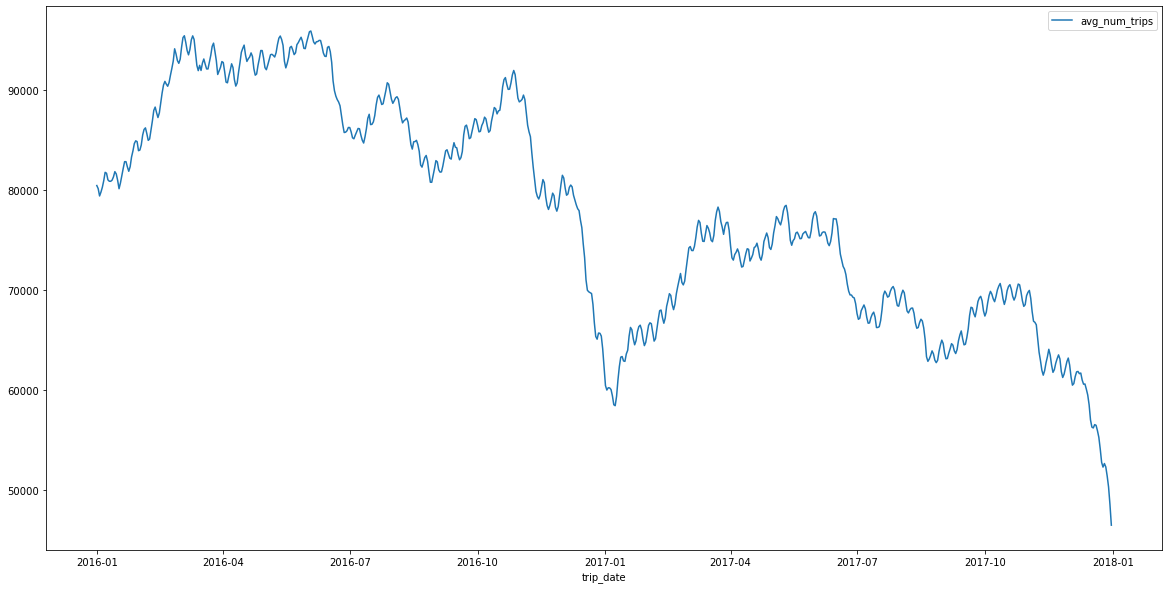

In [48]:
df.set_index('trip_date').plot(figsize=(20,10))

## 2) Can you separate and order trips by community area?
Shows the order in which the trips were taken from their respective community areas.
-> show the order in which an order was taken from the respective customer

In [52]:
Image(url="https://cloud.google.com/bigquery/docs/reference/standard-sql/images/analytic-function-illustration.png")

In [51]:
%%bigquery

SELECT
  pickup_community_area,
  trip_start_timestamp,
  trip_end_timestamp,
  RANK()OVER(PARTITION BY pickup_community_area ORDER BY trip_start_timestamp) as trip_number
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  DATE(trip_start_timestamp) = '2017-05-01'

,pickup_community_area,trip_start_timestamp,trip_end_timestamp,trip_number
0,2.0,2017-05-01 00:00:00+00:00,2017-05-01 00:15:00+00:00,1
1,2.0,2017-05-01 00:00:00+00:00,2017-05-01 00:00:00+00:00,1
2,2.0,2017-05-01 00:00:00+00:00,2017-05-01 00:00:00+00:00,1
3,2.0,2017-05-01 00:15:00+00:00,2017-05-01 00:15:00+00:00,4
4,2.0,2017-05-01 00:15:00+00:00,2017-05-01 00:30:00+00:00,4
...,...,...,...,...
74718,73.0,2017-05-01 11:00:00+00:00,2017-05-01 11:30:00+00:00,3
74719,73.0,2017-05-01 12:15:00+00:00,2017-05-01 12:15:00+00:00,4
74720,73.0,2017-05-01 12:15:00+00:00,2017-05-01 12:30:00+00:00,4
74721,73.0,2017-05-01 17:45:00+00:00,2017-05-01 17:45:00+00:00,6


## 3) How much time elapses between trips (orders)?

In [53]:
%%bigquery

SELECT
  taxi_id,
  trip_start_timestamp,
  trip_end_timestamp,
  TIMESTAMP_DIFF( trip_start_timestamp, LAG(trip_end_timestamp) OVER (PARTITION BY taxi_id ORDER BY trip_start_timestamp), MINUTE) AS prev_break
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  DATE(trip_start_timestamp) = '2017-05-01'

,taxi_id,trip_start_timestamp,trip_end_timestamp,prev_break
0,0f2be663856dd9f20d52405f7e4f00e164fdf336bede0e...,2017-05-01 08:15:00+00:00,2017-05-01 08:30:00+00:00,NaN
1,0f2be663856dd9f20d52405f7e4f00e164fdf336bede0e...,2017-05-01 08:45:00+00:00,2017-05-01 08:45:00+00:00,15.0
2,0f2be663856dd9f20d52405f7e4f00e164fdf336bede0e...,2017-05-01 09:00:00+00:00,2017-05-01 09:15:00+00:00,15.0
3,0f2be663856dd9f20d52405f7e4f00e164fdf336bede0e...,2017-05-01 09:15:00+00:00,2017-05-01 09:30:00+00:00,0.0
4,0f2be663856dd9f20d52405f7e4f00e164fdf336bede0e...,2017-05-01 09:30:00+00:00,2017-05-01 09:45:00+00:00,0.0
...,...,...,...,...
74718,f57c52ac544fb55fe663b6629c3a431653f4fa63ee3c5d...,2017-05-01 12:00:00+00:00,2017-05-01 12:00:00+00:00,60.0
74719,f57c52ac544fb55fe663b6629c3a431653f4fa63ee3c5d...,2017-05-01 12:45:00+00:00,2017-05-01 12:45:00+00:00,45.0
74720,f57c52ac544fb55fe663b6629c3a431653f4fa63ee3c5d...,2017-05-01 13:00:00+00:00,2017-05-01 13:30:00+00:00,15.0
74721,f57c52ac544fb55fe663b6629c3a431653f4fa63ee3c5d...,2017-05-01 13:45:00+00:00,2017-05-01 13:45:00+00:00,15.0
